# CES-2024 Final Project

In [286]:
pip install pyrolite

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [287]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from pyrolite.plot import pyroplot
from itertools import product

# Computational Earth Science Final Fall '24
## Matt Sudia - ms6650@columbia.edu
## Due: 12/05/2024

In [292]:
# Kd from Basanite CPX
data = pd.read_csv('cREEs.csv')
data

,Element,Z,CC,PM (BSE),DM,MORBs,VIABs,UCC,LCC,Kd_low,Kd_high
0,La57,57.0,0.2347,0.6860,0.1920,4.1300,5.9800,31.0000,8.0000,0.003,0.0200
1,Ce58,58.0,0.6032,1.7850,0.0550,11.4600,14.3900,63.0000,20.0000,0.004,0.0400
2,Nd60,60.0,0.4524,1.3270,0.5810,9.3000,8.8000,27.0000,11.0000,0.010,0.0700
3,Sm62,62.0,0.1471,0.4310,0.2390,2.9600,2.3300,4.7000,2.8000,0.030,0.1000
4,Eu63,63.0,0.0580,0.1620,0.0960,1.1300,0.8000,1.0000,1.1000,0.030,0.0800
5,Gd64,64.0,0.1966,0.5710,0.3580,4.0400,2.2800,4.0000,3.1000,0.040,0.0900
6,Tb65,65.0,0.0375,0.1050,0.0700,0.6800,0.4300,0.7000,0.5000,0.040,0.1000
7,Dy66,66.0,0.2427,0.7110,0.5050,4.7000,2.8100,3.9000,3.1000,0.030,0.0800
8,Ho67,67.0,0.0567,0.1590,0.1570,0.9300,0.5200,0.8300,0.7000,0.040,0.1000
9,Er68,68.0,0.1589,0.4650,0.3480,3.0000,1.3600,2.3000,1.9000,0.040,0.1000


In [293]:
data.set_index('Element', inplace=True)
data = data.drop('Source')
data['Z'] = data['Z'].astype(int)
data.set_index('Z', inplace=True)
data

,CC,PM (BSE),DM,MORBs,VIABs,UCC,LCC,Kd_low,Kd_high
Z,,,,,,,,,
57,0.2347,0.6860,0.1920,4.1300,5.9800,31.0000,8.0000,0.003,0.0200
58,0.6032,1.7850,0.0550,11.4600,14.3900,63.0000,20.0000,0.004,0.0400
60,0.4524,1.3270,0.5810,9.3000,8.8000,27.0000,11.0000,0.010,0.0700
62,0.1471,0.4310,0.2390,2.9600,2.3300,4.7000,2.8000,0.030,0.1000
63,0.0580,0.1620,0.0960,1.1300,0.8000,1.0000,1.1000,0.030,0.0800
64,0.1966,0.5710,0.3580,4.0400,2.2800,4.0000,3.1000,0.040,0.0900
65,0.0375,0.1050,0.0700,0.6800,0.4300,0.7000,0.5000,0.040,0.1000
66,0.2427,0.7110,0.5050,4.7000,2.8100,3.9000,3.1000,0.030,0.0800
67,0.0567,0.1590,0.1570,0.9300,0.5200,0.8300,0.7000,0.040,0.1000


In [294]:
zlabels = ['La57', 'Ce58', 'Nd60', 'Sm62', 'Eu63', 'Gd64', 'Tb65', 'Dy66', 'Ho67', 'Er68', 'Yb70', 'Lu71']
zlabels

['La57',
 'Ce58',
 'Nd60',
 'Sm62',
 'Eu63',
 'Gd64',
 'Tb65',
 'Dy66',
 'Ho67',
 'Er68',
 'Yb70',
 'Lu71']

## Melting and Compatibility
Kd or D represents the partition coefficient (or Bulk Partition coefficient for D) of an element, mineral, or rock.

An element with a Kd > 1 is more concentrated in the solid as opposed to the melt, and is considered ***compatible*** in the solid.

An element with a Kd < 1 is less concentrated in the solid and more in the melt and is considered ***incompatible*** in the solid.

An element with a Kd = 1 is equally concentrated in the solid and the melt and is considered ***neutral***.

Melting is often described either as *Batch Melting* or *Fractional Melting*. **Batch melting** is also known as equilibrium melting and assumes that the melt remains in equilibrium with the solid phase throughout the melting process. All the melt generated stays in contact with the residual solid until the melting stops. How this is shows up is that the melt's composition is an average of what has been extracted from the source, reflecting a balance between compatible and incompatible elements. Meanwhile, **Fractional Melting** assumes that the melt is immediately removed from the residual solid as it forms. There is no continuous interaction or equilibrium between the melt and the solid after the melt is generated. This is reflected in the final melt in that it is more enriched in incompatible elements compared to batch melting, especially in the early stages of melting. This is because incompatible elements are preferentially incorporated into the melt, and they are not continuously equilibrating with the residual solid.

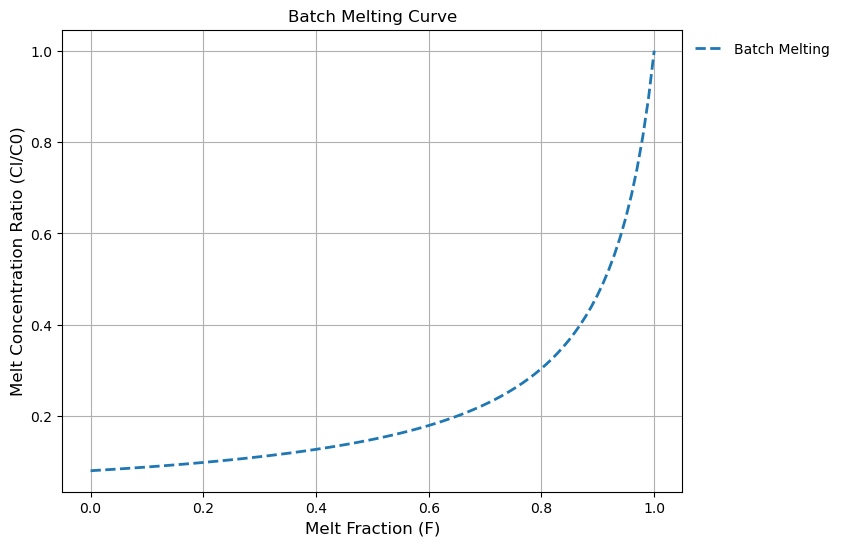

In [386]:
# Creating a function for batch melting:
def batch_melting(C0, D, F):
    """
    Calculates the concentration of an element in melt via batch melting equation
    
    C0: Initial element concentration in source
    D: Bulk partition coefficient
    F: Melt fraction (0 to 1)
    Cl/C0 = Ratio of concentration in melt vs. initial concentration
    
    Returns Cl/C0 ratio
    """
    Cl = C0 / (D * (1 - F) + F)
    return Cl

# Example parameters to test:
C0 = 0.43
D = 12.43 # Partition Coefficient for a highly compatible element
F = np.linspace(0.00, 1.0, 100)

# Calculate:
Cl_batch = batch_melting(C0, D, F)
batch_ratio = Cl_batch/C0

# Plot:
plt.figure(figsize=(8, 6))
plt.plot(F, Cl_batch/C0, label='Batch Melting', linewidth=2, linestyle='--')
plt.xlabel('Melt Fraction (F)')
plt.ylabel('Melt Concentration Ratio (Cl/C0)')
plt.title('Batch Melting Curve')
plt.legend()
plt.grid(True)
plt.show()

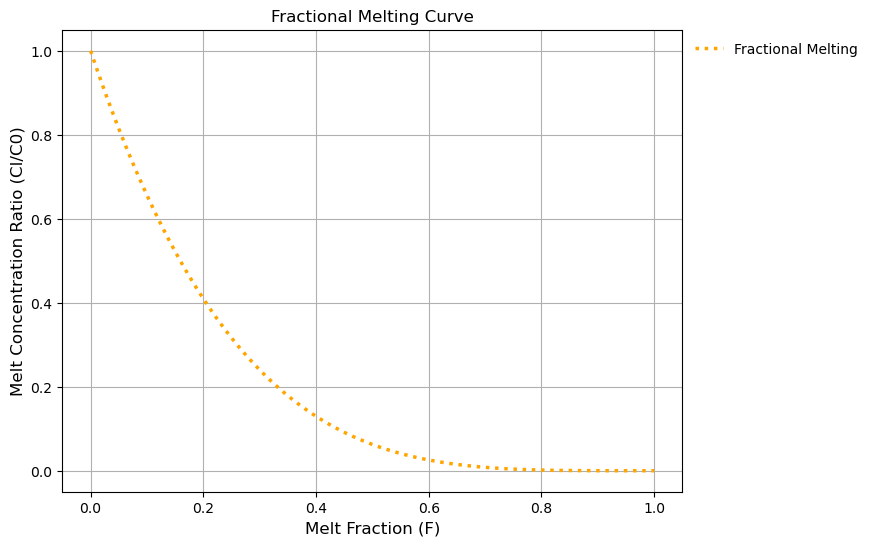

In [389]:
def fract_melting(C0, D, F):
    """
    Calculates the concentration of an element in melt via fractional melting equation
    
    C0: Initial element concentration in source
    D: Bulk partition coefficient
    F: Melt fraction (0 to 1)
    Cl/C0 = Ratio of concentration in melt vs. initial concentration
    
    Returns Cl/C0 ratio
    """
    Cl = C0 * (1 - F)**((1 - D) / D)
    return Cl

# Example parameters to test:
C0 = 0.5
D = 0.2 # Partition Coefficient for a highly incompatible element
F = np.linspace(0.00, 1.00, 100)

# Calculate:
Cl_fract = fract_melting(C0, D, F)
fract_ratio = Cl_fract/C0

# Plot:
plt.figure(figsize=(8, 6))
plt.plot(F, fract_ratio, label='Fractional Melting', color='orange', linewidth=2.5, linestyle=':')
plt.xlabel('Melt Fraction (F)')
plt.ylabel('Melt Concentration Ratio (Cl/C0)')
plt.title('Fractional Melting Curve')
plt.legend()
plt.grid(True)
plt.show()

In [384]:
# Generating some random initial concentrations:
print(np.random.uniform(0, 10))
print(np.random.uniform(0, 10))

2.2218165550986093
4.680008193579796


In [395]:
# Can place them together to compare:
# Initial Concentrations & Bulk Partition Coefficients:
comp_C0 = 2.22
incomp_C0 = 4.68
comp_D = 1.5
incomp_D = 0.5
F = np.arange(0.00, 1.00, 0.01)

# Calculations
comp_batch = batch_melting(comp_C0, comp_D, (1-F))
comp_fract = fract_melting(comp_C0, comp_D, F)
incomp_batch = batch_melting(incomp_C0, incomp_D, (1-F))
incomp_fract = fract_melting(incomp_C0, incomp_D, F)

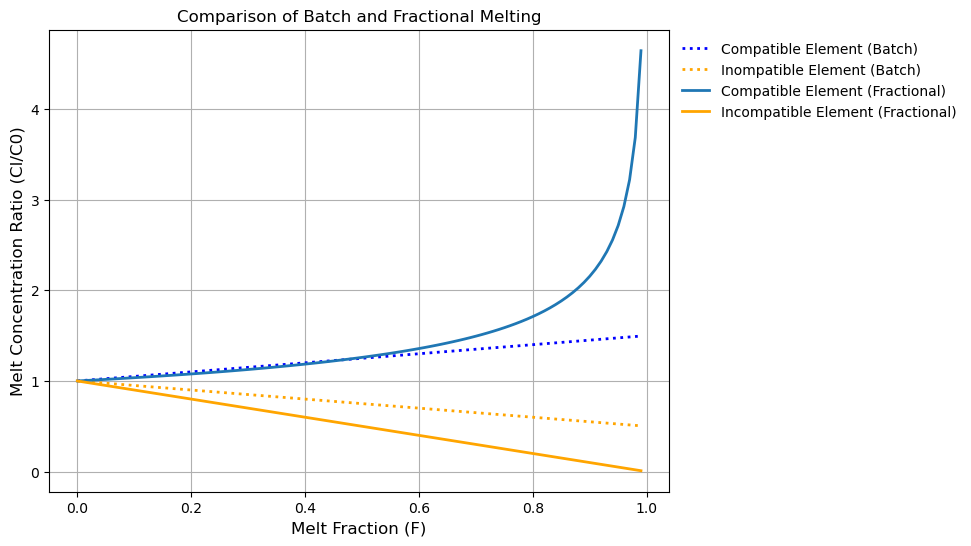

In [401]:
# Plotting comparison
plt.figure(figsize=(8, 6))
plt.plot(F, 1/(comp_batch/comp_C0), label='Compatible Element (Batch)', color='blue', linestyle=':', linewidth=2)
plt.plot(F, 1/(incomp_batch/incomp_C0), label='Inompatible Element (Batch)', color='orange', linestyle=':', linewidth=2)
plt.plot(F, comp_fract/comp_C0, label='Compatible Element (Fractional)', linestyle='-', linewidth=2)
plt.plot(F, incomp_fract/incomp_C0, label='Incompatible Element (Fractional)', color='orange', linestyle='-', linewidth=2)
plt.xlabel('Melt Fraction (F)')
plt.ylabel('Melt Concentration Ratio (Cl/C0)')
plt.title('Comparison of Batch and Fractional Melting')
plt.legend()
plt.grid(True)
plt.show()

In [300]:
# Georeservoirs
C1C = data['CC']       # C1 Carbonaceous Chondrites; stand-in for Solar-System baseline composition
BSE = data['PM (BSE)'] # Bulk Silicate Earth, formerly Primitive Mantle; Mantle before differentiation
DM = data['DM']        # Depleted Mantle
MORB = data['MORBs']   # Mid-ocean ridge basalts
OIB = data['VIABs']    # Ocean-island basalts
UCC = data['UCC']      # Upper Continental Crust
LCC = data['LCC']      # Lower Continental Crust

In [301]:
znumbers = list([57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71])
print(znumbers)
print(zlabels)

[57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71]
['La57', 'Ce58', 'Nd60', 'Sm62', 'Eu63', 'Gd64', 'Tb65', 'Dy66', 'Ho67', 'Er68', 'Yb70', 'Lu71']


In [302]:
C1C = np.array(C1C)
BSE = np.array(BSE)
DM = np.array(DM)
MORB = np.array(MORB)
OIB = np.array(OIB)
UCC = np.array(UCC)
LCC = np.array(LCC)

In [303]:
# Converting float64 vs. strings
C1C = C1C.astype(np.float64)
BSE = BSE.astype(np.float64)
DM = DM.astype(np.float64)
MORB = MORB.astype(np.float64)
OIB = OIB.astype(np.float64)
UCC = UCC.astype(np.float64)
LCC = LCC.astype(np.float64)

In [304]:
# Normalized to Chondrite
C1Cn = 1
BSEn = BSE/C1C
DMn = DM/C1C
MORBn = MORB/C1C
OIBn = OIB/C1C
UCCn = UCC/C1C
LCCn = LCC/C1C

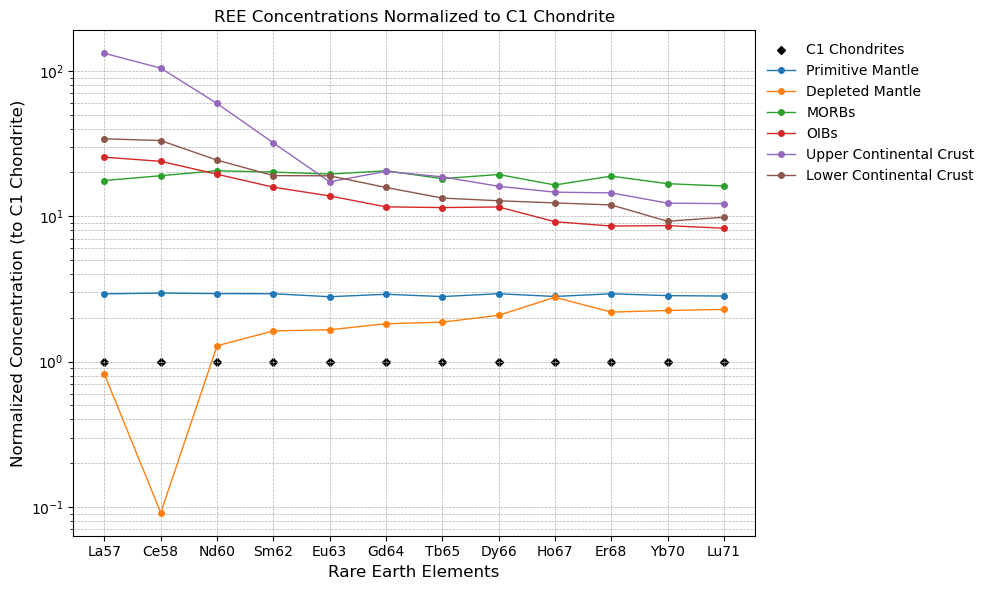

In [305]:
plt.figure(figsize=(10, 6))

# Chondrite baseline
plt.scatter(zlabels, np.ones_like(C1C), label='C1 Chondrites', color='black')

# Georeservoirs
plt.plot(zlabels, BSEn, label='Primitive Mantle', marker='o')
plt.plot(zlabels, DMn, label='Depleted Mantle', marker='o')
plt.plot(zlabels, MORBn, label='MORBs', marker='o')
plt.plot(zlabels, OIBn, label='OIBs', marker='o')
plt.plot(zlabels, UCCn, label='Upper Continental Crust', marker='o')
plt.plot(zlabels, LCCn, label='Lower Continental Crust', marker='o')

# Log scale***
plt.yscale('log')

# Plot logistics
plt.xlabel('Rare Earth Elements')
plt.ylabel('Normalized Concentration (to C1 Chondrite)')
plt.title('REE Concentrations Normalized to C1 Chondrite')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

In [306]:
Kd_low = np.array(data['Kd_low']).astype(np.float64)
Kd_high = np.array(data['Kd_high']).astype(np.float64)
print(Kd_low)
print(Kd_high)

[0.003 0.004 0.01  0.03  0.03  0.04  0.04  0.03  0.04  0.04  0.1   0.17 ]
[0.02 0.04 0.07 0.1  0.08 0.09 0.1  0.08 0.1  0.1  0.4  0.6 ]


In [307]:
# Depleted Mantle to MORB melting diagram
# (C0, D, F) ; (dm_C0, Kd_low/Kd_high, F)
# batch_melting(...)
# fract_melting(...)
# Depleted Mantle low
dm_C0 = BSE
F = np.linspace(0.01, 0.99, 100) 

Kd_avg = (Kd_low+Kd_high)/2

results_low = {}  # Kd_low
results_high = {} # Kd_high
results_avg = {}  # Kd_avg

In [308]:
Kd_avg

array([0.0115, 0.022 , 0.04  , 0.065 , 0.055 , 0.065 , 0.07  , 0.055 ,
       0.07  , 0.07  , 0.25  , 0.385 ])

In [309]:
# For-loop for each REE
for i, element in enumerate(zlabels):
    C0 = dm_C0[i]
    D = Kd_low[i]
    results_low[element] = fract_melting(C0, D, F)

In [310]:
# For-loop for each REE
for i, element in enumerate(zlabels):
    C0 = dm_C0[i]
    D = Kd_high[i]
    results_high[element] = fract_melting(C0, D, F)

In [311]:
# For-loop for each REE
for i, element in enumerate(zlabels):
    C0 = dm_C0[i]
    D = Kd_avg[i]
    results_avg[element] = fract_melting(C0, D, F)

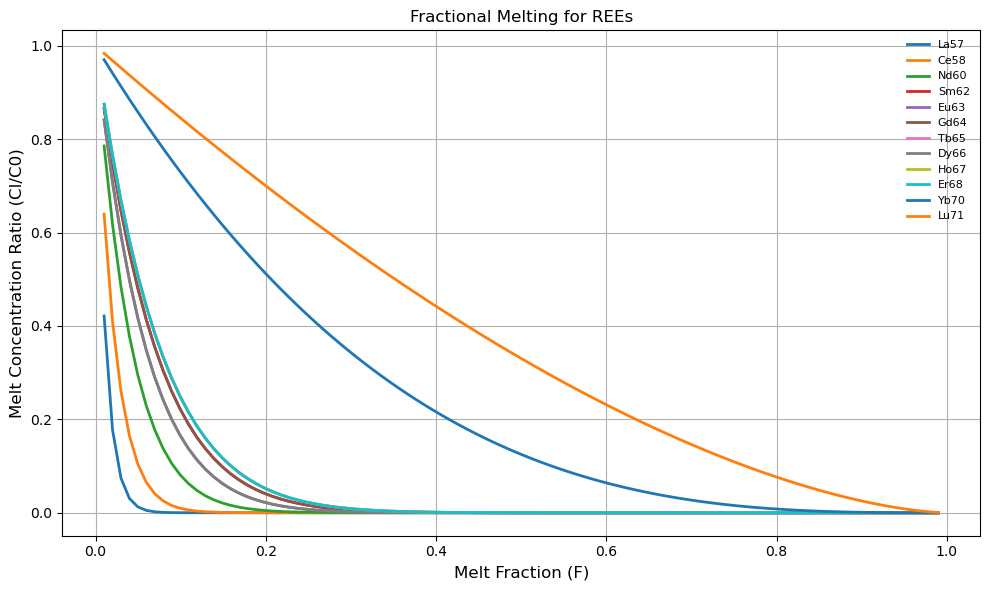

In [313]:
# Plot results
plt.figure(figsize=(10, 6))
for element in zlabels:
    plt.plot(F, results_avg[element], label=f'{element}', linewidth = 2)

# Formatting the plot
plt.xlabel('Melt Fraction (F)')
plt.ylabel('Melt Concentration Ratio (Cl/C0)')
plt.title('Fractional Melting for REEs')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [314]:
# Again, translate data from string to int/float
tdata = np.array(data).astype(np.float64)

In [315]:
cols = ['C1C','BSE','DM','MORB','OIB','UCC','LCC','Kd_low','Kd_high']
tdata = pd.DataFrame(tdata, columns=cols)
tdata

,C1C,BSE,DM,MORB,OIB,UCC,LCC,Kd_low,Kd_high
0,0.2347,0.6860,0.192,4.13,5.98,31.00,8.00,0.003,0.02
1,0.6032,1.7850,0.055,11.46,14.39,63.00,20.00,0.004,0.04
2,0.4524,1.3270,0.581,9.30,8.80,27.00,11.00,0.010,0.07
3,0.1471,0.4310,0.239,2.96,2.33,4.70,2.80,0.030,0.10
4,0.0580,0.1620,0.096,1.13,0.80,1.00,1.10,0.030,0.08
5,0.1966,0.5710,0.358,4.04,2.28,4.00,3.10,0.040,0.09
6,0.0375,0.1050,0.070,0.68,0.43,0.70,0.50,0.040,0.10
7,0.2427,0.7110,0.505,4.70,2.81,3.90,3.10,0.030,0.08
8,0.0567,0.1590,0.157,0.93,0.52,0.83,0.70,0.040,0.10
9,0.1589,0.4650,0.348,3.00,1.36,2.30,1.90,0.040,0.10


In [316]:
tdata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   C1C      12 non-null     float64
 1   BSE      12 non-null     float64
 2   DM       12 non-null     float64
 3   MORB     12 non-null     float64
 4   OIB      12 non-null     float64
 5   UCC      12 non-null     float64
 6   LCC      12 non-null     float64
 7   Kd_low   12 non-null     float64
 8   Kd_high  12 non-null     float64
dtypes: float64(9)
memory usage: 996.0 bytes


In [317]:
cols = ['DM','MORB','UCC']
dft = tdata[cols].div(tdata[cols].sum(axis=1), axis=0)
print(dft.head())

         DM      MORB       UCC
0  0.005436  0.116924  0.877640
1  0.000738  0.153795  0.845467
2  0.015753  0.252162  0.732084
3  0.030257  0.374731  0.595012
4  0.043127  0.507637  0.449236


In [344]:
# Parameters:
# Initial concentration for La57 in DM/MORB
C01min = DM[0]-(DM[0]/2)
C01max = DM[0]+(DM[0]/2)
C01 = np.linspace(C01min, C01max, 100)
C02min = MORB[0]-(MORB[0]/2)
C02max = MORB[0]+(MORB[0]/2)
C02 = np.linspace(C02min, C02max, 100)

# Fixed Melt Fraction & Average Partition Coefficient
F = 0.5
D = Kd_avg[0]

# Create a meshgrid for D1 and D2
C1, C2 = np.meshgrid(C01, C02)

# Calculate melt concentrations for each combination of D1 and D2
cDM1 = fract_melting(C1, D, F)
cMORB1 = fract_melting(C2, D, F)
ratio1 = cDM1/cMORB1

In [345]:
np.min(cDM1)

1.2787329810035805e-27

In [346]:
min = np.min(cDM1)
max = np.max(cDM1)
print("Range:", min, "to", max)
min = np.min(cMORB1)
max = np.max(cMORB2)
print("Range:", min, "to", max)
min = np.min(ratio1)
max = np.max(ratio1)
print("Range:", min, "to", max)

Range: 1.2787329810035805e-27 to 3.836198943010742e-27
Range: 2.7506079226795765e-26 to 4.7
Range: 0.01549636803874092 to 0.13946731234866833


In [347]:
# Parameters:
# Initial concentration for La57 in DM/MORB
C01min = DM[7]-(DM[7]/2)
C01max = DM[7]+(DM[7]/2)
C01 = np.linspace(C01min, C01max, 100)
C02min = MORB[7]-(MORB[7]/2)
C02max = MORB[7]+(MORB[7]/2)
C02 = np.linspace(C02min, C02max, 100)

# Fixed Melt Fraction & Average Partition Coefficient
F = 0.5
D = Kd_avg[0]

# Create a meshgrid for D1 and D2
C1, C2 = np.meshgrid(C01, C02)

# Calculate melt concentrations for each combination of D1 and D2
cDM2 = fract_melting(C1, D, F)
cMORB2 = fract_melting(C2, D, F)
ratio2 = cDM2/cMORB2

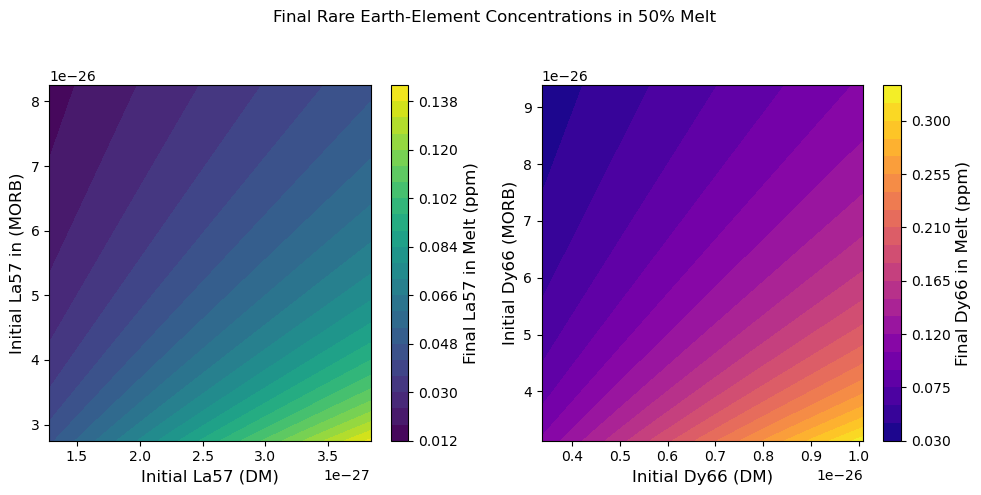

In [357]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# First contour plot
contour1 = axes[0].contourf(cDM1, cMORB1, ratio1, levels=20, cmap='viridis')
axes[0].set_xlabel('Initial La57 (DM)')
axes[0].set_ylabel('Initial La57 in (MORB)')
cbar1 = fig.colorbar(contour1, ax=axes[0], label='Final La57 in Melt (ppm)')

# Second contour plot
contour2 = axes[1].contourf(cDM2, cMORB2, ratio2, levels=20, cmap='plasma')
axes[1].set_xlabel('Initial Dy66 (DM)')
axes[1].set_ylabel('Initial Dy66 (MORB)')
cbar2 = fig.colorbar(contour2, ax=axes[1], label='Final Dy66 in Melt (ppm)')

# Set the overall title for the figure
fig.suptitle('Final Rare Earth-Element Concentrations in 50% Melt')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Show the plot
plt.show()

In [ ]:
data

In [331]:
# Ternary Mixing
# Lets imagine that a melt occurs in an area that causes the Depleted Mantle, Lower Continental, and Upper Continental crust
# To mix. If we look at the concentration of one element, such as Neodymium (Nd60), we can see how the concentration of
# the element changes based on mixing between the three georeservoirs.
# Nd60 = [2,] | DM[,2] | UCC[,5] | LCC[,6]
# Ratios = [2,7] (low) and [2,8] (high)
tdata = np.array(data).astype(np.float64)
total_Nd = tdata[2,2] + tdata[2,5] + tdata[2,6]

In [332]:
# Nd Concentrations from data
cDM_Nd = tdata[2,2]
cUCC_Nd = tdata[2,2]
cLCC_Nd = tdata[2,2]

# Hypothetical mass ratios
rDM_Nd = np.random.uniform(0, 0.05)
rUCC_Nd = np.random.uniform(0, 0.1)
rLCC_Nd = np.random.uniform(0, 0.15)

In [333]:
print(rDM_Nd)
print(rUCC_Nd)
print(rLCC_Nd)

0.01578593989713589
0.040601657720702594
0.13675657096887037


In [334]:
fract = np.arange(1,101,1) / 100

In [335]:
combos = [(a, b, c) for a, b, c in product(fract, fract, fract) if np.isclose(a + b + c, 1.0)]

In [336]:
A_values, B_values, C_values = zip(*combos)

Nd_mixed = []

for DM_frac, UCC_frac, LCC_frac in zip(A_values, B_values, C_values):
    Nd_ratio = (rDM_Nd * cDM_Nd * DM_frac +
                rUCC_Nd * cUCC_Nd * UCC_frac +
                rLCC_Nd * cLCC_Nd * LCC_frac) / \
               (cDM_Nd * DM_frac + cUCC_Nd * UCC_frac + cLCC_Nd * LCC_frac)
    Nd_mixed.append(Nd_ratio)

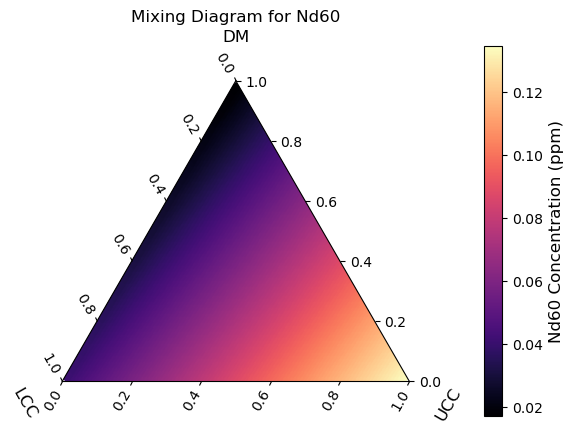

In [340]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='ternary')

sc = ax.scatter(A_values, B_values, C_values, c=Nd_mixed, cmap='magma', label='Neodymium')
ax.set_title("Mixing Diagram for Nd60")
ax.set_tlabel("DM")
ax.set_llabel("LCC")
ax.set_rlabel("UCC")

plt.colorbar(sc, label='Nd60 Concentration (ppm)', pad=0.15)

plt.savefig('ternary_Sr', bbox_inches='tight')